In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc=Client(profile='mpi')

In [2]:
%%px
# Import main modules
import pyfftw as ft 
import numpy as np
from mpi4py import MPI
import math
import sys

# Import modules of our interest
from DatasetOnVM import DatasetOnVM
from FFT3Dfield import FFT3Dfield
from EnergySpectrum import EnergySpectrum
from Filters import Filters

comm = MPI.COMM_WORLD
my_id = comm.Get_rank()
nproc = comm.Get_size()

if(my_id==0):
    sys.stdout.write('Starting with processors:%d\n' %(int(nproc)))

[stdout:0] Starting with processors:8


In [3]:
%%px
# Domain info:
nx=1024
ny=1024
nz=1024

lx=nx//nproc
ly=ny
lz=nz
nek=int(math.sqrt(2.0)/3*nx)

sys.stdout.write('MPI id:%d; divided on block size (Nx,Ny,Nz): (%d,%d,%d)\n' %(my_id,lx,ly,lz))

[stdout:0] MPI id:0; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:1] MPI id:6; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:2] MPI id:1; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:3] MPI id:5; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:4] MPI id:7; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:5] MPI id:3; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:6] MPI id:2; divided on block size (Nx,Ny,Nz): (128,1024,1024)
[stdout:7] MPI id:4; divided on block size (Nx,Ny,Nz): (128,1024,1024)


In [4]:
%%px
# load dataset from local drive:

dirName='/home/idies/workspace/scratch/dataSnapshot/'
fileNameInitial='veldata_myID'
myDataset=DatasetOnVM()

comm.Barrier(); t1=MPI.Wtime()
#vx,vy,vz=myDataset.LoadDataFromVM(dirName,fileNameInitial,nproc,my_id)
vx,vy,vz=myDataset.LoadDataFromVM(dirName,fileNameInitial,nproc,my_id,lx,ly,lz)
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Load velocity fields cost: %0.2f seconds\n' %(t2-t1))

[stdout:0] Load velocity fields cost: 15.79 seconds


In [5]:
%%px
## Get velocity field in wavenumber space:
comm.Barrier(); t1=MPI.Wtime()
myFFT3Dfield=FFT3Dfield()
cvx=myFFT3Dfield.GetFFT3Dfield(vx,lx,ly,lz,nproc,my_id)
cvy=myFFT3Dfield.GetFFT3Dfield(vy,lx,ly,lz,nproc,my_id)
cvz=myFFT3Dfield.GetFFT3Dfield(vz,lx,ly,lz,nproc,my_id)
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('3 R-C FFTs cost: %0.2f seconds\n' %(t2-t1))

[stdout:0] 3 R-C FFTs cost: 74.57 seconds


In [6]:
%%px
## Get wavenumber:
comm.Barrier(); t1=MPI.Wtime()
myEnergySpc=EnergySpectrum()
out_res=myEnergySpc.FindWavenumber(lx,ly,lz,my_id)
k2=out_res[0]
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Wavenumber calculation cost: %0.2f seconds\n' %(t2-t1))

[stdout:0] Wavenumber calculation cost: 10.37 seconds


In [7]:
%%px
## Get energy spectrum in Fourier space
comm.Barrier(); t1=MPI.Wtime()
ek_all=myEnergySpc.GetSpectrumFromComplexField(cvx,cvy,cvz,k2,lx,ly,lz,nek,nproc,my_id)
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Energy spec calculation cost: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] Energy spec calculation cost: 27.23 seconds


[output:0]

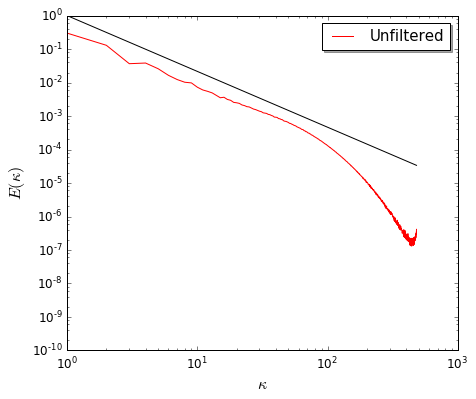

In [8]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if(my_id==0):
    ks=np.linspace(1,nek,nek)
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.figure(figsize=(7,6))
    plt.loglog(ks,ek_all,'r',label='Unfiltered')    
    plt.loglog(ks,np.power(ks,-5/3),'k')    
    plt.xlabel('$\kappa$')
    plt.ylabel('$E(\kappa)$')
    plt.axis([0.0,1000.0, 1e-10,1.0])
    plt.legend(loc=0, shadow=True) #loc='upper center'
    ax = plt.gca()
    ax.set_autoscale_on(False)    

In [9]:
%%px
## Filter the velocity field using the GAUSSIAN filter
kappa_c=100.0
comm.Barrier(); t1=MPI.Wtime()
myFilter=Filters()
cvx1=myFilter.FilterTheComplexField(cvx,k2,kappa_c,'gaussian')
cvy1=myFilter.FilterTheComplexField(cvy,k2,kappa_c,'gaussian')
cvz1=myFilter.FilterTheComplexField(cvz,k2,kappa_c,'gaussian')
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Gaussian filtering calculation cost: {0:.2f} seconds\n'.format(t2-t1))
    
## Get energy spectrum in Fourier space
ek_gaussian=myEnergySpc.GetSpectrumFromComplexField(cvx1,cvy1,cvz1,k2,lx,ly,lz,nek,nproc,my_id)

del cvx1
del cvy1
del cvz1

[stdout:2] Gaussian filtering calculation cost: 36.67 seconds


[output:2]

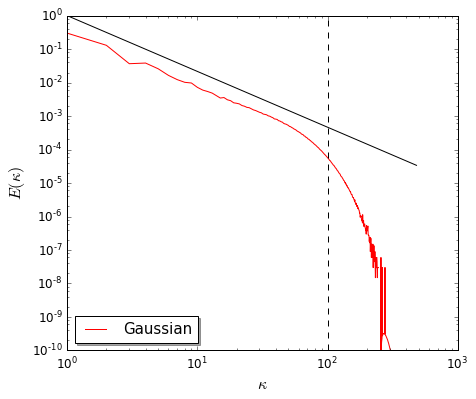

In [10]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if(my_id==0):
    ks=np.linspace(1,nek,nek)
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.figure(figsize=(7,6))
    plt.loglog(ks,ek_gaussian,'r',label='Gaussian')    
    plt.loglog(ks,np.power(ks,-5/3),'k')
    plt.loglog([kappa_c,kappa_c],[1.e-10,1],'k--')
    plt.xlabel('$\kappa$')
    plt.ylabel('$E(\kappa)$')
    plt.axis([0.0,1000.0, 1e-10,1.0])
    plt.legend(loc=0, shadow=True) #loc='upper center'
    ax = plt.gca()
    ax.set_autoscale_on(False)

In [11]:
%%px
## Filter the velocity field using the SHARP filter
kappa_c=100.0
comm.Barrier(); t1=MPI.Wtime()
myFilter=Filters()
cvx1=myFilter.FilterTheComplexField(cvx,k2,kappa_c,'sharp')
cvy1=myFilter.FilterTheComplexField(cvy,k2,kappa_c,'sharp')
cvz1=myFilter.FilterTheComplexField(cvz,k2,kappa_c,'sharp')
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Sharp filtering calculation cost: {0:.2f} seconds\n'.format(t2-t1))

## Get energy spectrum in Fourier space
ek_sharp=myEnergySpc.GetSpectrumFromComplexField(cvx1,cvy1,cvz1,k2,lx,ly,lz,nek,nproc,my_id)

del cvx1
del cvy1
del cvz1

[stdout:2] Sharp filtering calculation cost: 18.26 seconds


[output:2]

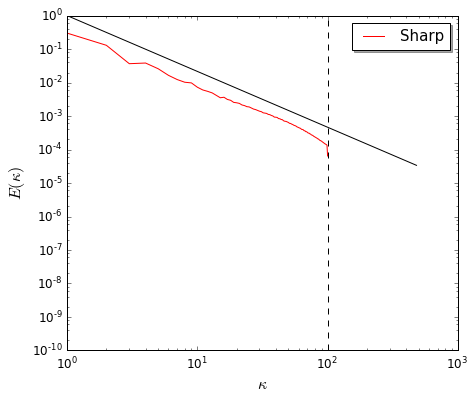

In [12]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if(my_id==0):
    ks=np.linspace(1,nek,nek)
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.figure(figsize=(7,6))
    plt.loglog(ks,ek_sharp,'r',label='Sharp')    
    plt.loglog(ks,np.power(ks,-5/3),'k')
    plt.loglog([kappa_c,kappa_c],[1.e-10,1],'k--')
    plt.xlabel('$\kappa$')
    plt.ylabel('$E(\kappa)$')
    plt.axis([0.0,1000.0, 1e-10,1.0])
    plt.legend(loc=0, shadow=True) #loc='upper center'
    ax = plt.gca()
    ax.set_autoscale_on(False)

In [13]:
%%px
## Filter the velocity field using the BOX filter
kappa_c=100.0
comm.Barrier(); t1=MPI.Wtime()
myFilter=Filters()
cvx1=myFilter.FilterTheComplexField(cvx,k2,kappa_c,'box')
cvy1=myFilter.FilterTheComplexField(cvy,k2,kappa_c,'box')
cvz1=myFilter.FilterTheComplexField(cvz,k2,kappa_c,'box')
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Box filtering calculation cost: {0:.2f} seconds\n'.format(t2-t1))

## Get energy spectrum in Fourier space
ek_box=myEnergySpc.GetSpectrumFromComplexField(cvx1,cvy1,cvz1,k2,lx,ly,lz,nek,nproc,my_id)

del cvx1
del cvy1
del cvz1

[stdout:2] Box filtering calculation cost: 44.96 seconds


[output:2]

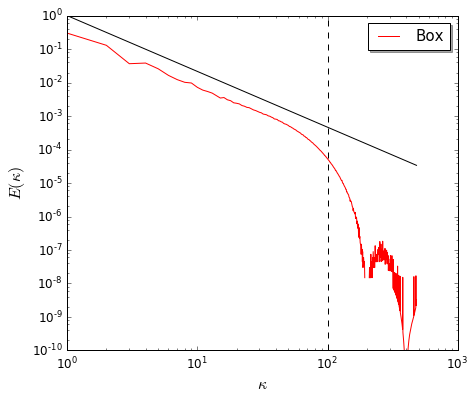

In [14]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if(my_id==0):
    ks=np.linspace(1,nek,nek)
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.figure(figsize=(7,6))
    plt.loglog(ks,ek_box,'r',label='Box')    
    plt.loglog(ks,np.power(ks,-5/3),'k')
    plt.loglog([kappa_c,kappa_c],[1.e-10,1],'k--')
    plt.xlabel('$\kappa$')
    plt.ylabel('$E(\kappa)$')
    plt.axis([0.0,1000.0, 1e-10,1.0])
    plt.legend(loc=0, shadow=True) #loc='upper center'
    ax = plt.gca()
    ax.set_autoscale_on(False)